In [36]:
import cv2
import matplotlib.pyplot as plt
import mediapipe
import numpy as np
import pandas as pd
import math
from PIL import Image

import os, time

import face_recognition  as fr
from PIL import Image, ImageDraw

In [6]:
def load_image( path ):
    img_base = cv2.imread( path )
    img_proc = cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB)
    return img_proc

In [7]:
def getLandmarkCenter(img, landmarks, facial_area_obj):
    lmrk_routes = []
    for source_idx, target_idx in facial_area_obj:
        # print(source_idx, target_idx)
        source = landmarks.landmark[source_idx]
        target = landmarks.landmark[target_idx]
    
        relative_source = (int(img.shape[1] * source.x), int(img.shape[0] * source.y))
        relative_target = (int(img.shape[1] * target.x), int(img.shape[0] * target.y))
        
        lmrk_routes.append(relative_source)
        lmrk_routes.append(relative_target)
    
        # cv2.line(img, relative_source, relative_target, (255, 255, 255), thickness = 2)
    lmrk_min_x_pt = min(lmrk_routes, key=lambda x: x[0])
    lmrk_max_x_pt = max(lmrk_routes, key=lambda x: x[0])
    lmrk_min_y_pt = min(lmrk_routes, key=lambda x: x[1])
    lmrk_max_y_pt = max(lmrk_routes, key=lambda x: x[1])
    
    center = (int((lmrk_min_x_pt[0]+lmrk_max_x_pt[0])/2.0), int((lmrk_min_y_pt[1]+lmrk_max_y_pt[1])/2.0))
    # cv2.circle(img, center, 2, (255, 255, 255), thickness = 2)
    return center

In [8]:
 
mp_face_detection = mediapipe.solutions.face_detection
face_detector =  mp_face_detection.FaceDetection( min_detection_confidence = 0.6)

faceModule = mediapipe.solutions.face_mesh
face_mesh = faceModule.FaceMesh(static_image_mode=True)

def find_imp_cord( img):
    fd_results = face_detector.process(img)
    right_eye_center, left_eye_center = 0,0
    if fd_results.detections:
        if len(fd_results.detections)==1:
            print("Selected Number of Faces:", len(fd_results.detections))
            # check All Specific required landmark present or Not
            # face = fd_results.detections
            # landmarks = face.location_data.relative_keypoints
            # right_eye = (int(landmarks[0].x * img.shape[1]), int(landmarks[0].y * img.shape[0]))
            # left_eye = (int(landmarks[1].x * img.shape[1]), int(landmarks[1].y * img.shape[0]))
            # nose = (int(landmarks[2].x * img.shape[1]), int(landmarks[2].y * img.shape[0]))
            # mouth = (int(landmarks[3].x * img.shape[1]), int(landmarks[3].y * img.shape[0]))
            
            results = face_mesh.process(img )
            if results.multi_face_landmarks is None:  # image 180degree 
                new_img = Image.fromarray(img)
                img = np.array(new_img.rotate(180))
                results = face_mesh.process(img )
                
            landmarks = results.multi_face_landmarks[0]
            
            facial_area_obj = faceModule.FACEMESH_RIGHT_EYE
            right_eye_center = getLandmarkCenter(img, landmarks, facial_area_obj)
            
            facial_area_obj = faceModule.FACEMESH_LEFT_EYE
            left_eye_center = getLandmarkCenter(img, landmarks, facial_area_obj)

            # return right_eye_center, left_eye_center
        else:
            print("more than one face")
    else:
        print("No Face Detection")
    return right_eye_center, left_eye_center, img



In [9]:

def align_face(img_obj, right_eye_center, left_eye_center):
    # eye_1 = left_eye_center
    # eye_2 = right_eye_center
    
    # eye_2 = left_eye_center
    # eye_1 = right_eye_center
    # print(right_eye_center, left_eye_center)
    # right_eye, left_eye = right_eye_center, left_eye_center
    right_eye, left_eye = left_eye_center, right_eye_center
    # print(right_eye, left_eye)
    #--------------------
    #decide left and right eye
    # if eye_1[0] < eye_2[0]:
    #     left_eye = eye_1
    #     right_eye = eye_2
    # else:
    #     left_eye = eye_2
    #     right_eye = eye_1
    
    left_eye_x = left_eye[0]
    left_eye_y = left_eye[1]
    right_eye_x = right_eye[0]
    right_eye_y =right_eye[1]
    #----------------------
    #find rotation direction
    if left_eye_y > right_eye_y:
        point_3rd = (right_eye_x, left_eye_y)
        direction = -1 #rotate same direction to clock
        # print("rotate to clock direction")
    else:
        point_3rd = (left_eye_x, right_eye_y)
        direction = 1 #rotate inverse direction of clock
        # print("rotate to inverse clock direction")
    
    def euclidean_distance(a, b):
    	x1 = a[0]; y1 = a[1]
    	x2 = b[0]; y2 = b[1]
    
    	return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))
        
    #----------------------
    #find angle
    a = euclidean_distance(left_eye, point_3rd) # math.dist(left_eye, point_3rd)
    b = euclidean_distance(right_eye, point_3rd)
    c = euclidean_distance(right_eye, left_eye)
    
    cos_a = (b*b + c*c - a*a)/(2*b*c)
    #print("cos(a) = ", cos_a)
    angle = np.arccos(cos_a)
    #print("angle: ", angle," in radian")
    
    angle = (angle * 180) / math.pi
    # print("angle: ", angle," in degree")
    
    if direction == -1:
        angle = 90 - angle
    
    # print("angle: ", angle," in degree")
    #--------------------
    #rotate image
    
    new_img = Image.fromarray(img_obj)
    new_img = np.array(new_img.rotate(direction * angle))
    return new_img


In [10]:

def crop_face( img ):
    mp_face_mesh = mediapipe.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
    results = face_mesh.process( img )
    if results.multi_face_landmarks is None:
        return False, img
      
    landmarks = results.multi_face_landmarks[0]
    abc = mp_face_mesh.FACEMESH_FACE_OVAL
    df = pd.DataFrame(list( abc ), columns = ["p1", "p2"])
    
    routes_idx = []
    p1 = df.iloc[0]["p1"]
    p2 = df.iloc[0]["p2"]
    
    for i in range(0, df.shape[0]):
        obj = df[df["p1"] == p2]
        p1 = obj["p1"].values[0]
        p2 = obj["p2"].values[0]
        route_idx = []
        route_idx.append(p1)
        route_idx.append(p2)
        routes_idx.append(route_idx)
    
    routes = []
    for source_idx, target_idx in routes_idx:
        source = landmarks.landmark[source_idx]
        target = landmarks.landmark[target_idx]
            
        relative_source = (int(img.shape[1] * source.x), int(img.shape[0] * source.y))
        relative_target = (int(img.shape[1] * target.x), int(img.shape[0] * target.y))
    
        # cv2.line(img, relative_source, relative_target, (255, 255, 255), thickness = 2)
        # print(relative_source, relative_target)
        routes.append(relative_source)
        routes.append(relative_target)
    
    mask = np.zeros((img.shape[0], img.shape[1]))
    mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
    mask = mask.astype(bool)
     
    out = np.zeros_like(img)
    out[mask] = img[mask]
    
    df1 = pd.DataFrame(routes, columns = ["p1", "p2"])
    x1,y1,x2,y2 = min(df1['p1']), min(df1['p2']), max(df1['p1']), max(df1['p2']) 
    x1,y1,x2,y2 = max(0, x1), max(0, y1), max(0, x2), max(0, y2) 
    # img1 = img[y1:y2, x1:x2]
    img1 = out[y1:y2, x1:x2]
    return True, img1

In [84]:
path = r"Img/test27.jpg"
fileName = path.split('/')[-1]
out_filename = f"Temp_{time.strftime('%d%m%y%H%M%S', time.localtime())}_{fileName}.jpg"
output_file_path = os.path.join('Temp', out_filename)

start_time= time.time()

img_obj = load_image( path )
img_obj_aug = img_obj.copy()

right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )

if right_eye_center != 0:
    img_best = align_face(img_upd, right_eye_center, left_eye_center)
    flag, img_crop = crop_face( img_best )
    if flag:
        final_img = img_crop.copy()
        Image.fromarray(final_img).save(output_file_path)
        # save crop file
        image = fr.load_image_file(output_file_path)
        fc_landmark = fr.face_landmarks(image)
        # print(fc_landmark)
        if fc_landmark:
            # Face Landmark found using Face Recognition
            fc_encoding = fr.face_encodings(image)[0]
            # print(fc_encoding)
            req_time = round((time.time() - start_time), 2)
        else:
            os.remove(output_file_path)
            print("Please ensure Entire Face is visible.....!!!!!")
            req_time = round((time.time() - start_time), 2)
else:
    print("Abort...")
    req_time = round((time.time() - start_time), 2)

print("---  Overall Time in %s seconds ---" % (req_time))

Selected Number of Faces: 1
Please ensure Entire Face is visible.....!!!!!
---  Overall Time in 0.3 seconds ---


In [82]:
fc_encoding

array([-1.57866061e-01,  1.53237298e-01,  3.81011441e-02, -6.78260997e-02,
       -3.92209738e-02, -1.05602749e-01, -5.63614555e-02, -1.09690279e-01,
        1.97953492e-01, -5.20516150e-02,  1.77504152e-01,  6.19168160e-03,
       -1.75060183e-01, -1.49356857e-01, -8.07081759e-02,  1.21503636e-01,
       -1.11361384e-01, -2.15169683e-01, -4.25900593e-02, -9.20176506e-02,
        5.69995232e-02, -7.79400347e-04, -3.29464339e-02,  2.10352950e-02,
       -1.15339860e-01, -3.64368021e-01, -6.97962195e-02, -1.43140927e-01,
        3.70562077e-02, -4.79167774e-02,  1.86469406e-05, -2.07258519e-02,
       -1.60737827e-01, -8.51466209e-02,  2.93206926e-02,  9.73696038e-02,
       -2.59663500e-02,  6.42885175e-03,  1.94303080e-01, -9.65517294e-03,
       -1.34541512e-01, -1.22349197e-02,  9.75588858e-02,  2.97325552e-01,
        1.47726238e-01,  7.58567229e-02,  6.91196173e-02, -8.17596167e-02,
        1.19144052e-01, -2.02793181e-01,  1.29721776e-01,  1.27260566e-01,
        1.47792906e-01,  

In [80]:
path = r"Img/test.jpg"
fileName = path.split('/')[-1]
out_filename = f"Temp_{time.strftime('%d%m%y%H%M%S', time.localtime())}_{fileName}.jpg"
output_file_path = os.path.join('Temp', out_filename)

start_time= time.time()

img_obj = load_image( path )
img_obj_aug = img_obj.copy()

right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )

if right_eye_center != 0:
    pass
    img_best = align_face(img_upd, right_eye_center, left_eye_center)
    flag, img_crop = crop_face( img_best )
    if flag:
        final_img = img_crop.copy()
        Image.fromarray(final_img).save(output_file_path)
        # save crop file
        image = fr.load_image_file(output_file_path)
        fc_landmark = fr.face_landmarks(image)
        # print(fc_landmark)
        if fc_landmark:
            # Face Landmark found using Face Recognition
            fc_encoding = fr.face_encodings(image)[0]
            # print(fc_encoding)
            req_time = round((time.time() - start_time), 2)
        else:
            os.remove(output_file_path)
            print("Please ensure Entire Face is visible.....!!!!!")
else:
    print("Abort...")

print("---  Overall Time in %s seconds ---" % (req_time))

Selected Number of Faces: 1
---  Overall Time in 1.36 seconds ---


Selected Number of Faces: 1
Please ensure Entire Face is visible.....!!!!!


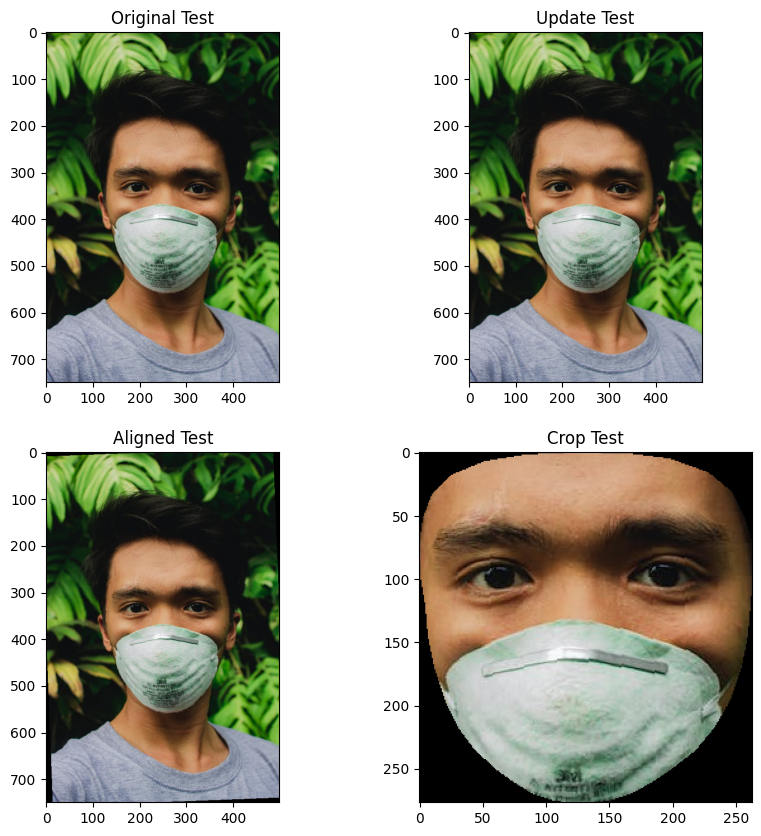

In [35]:
path = r"Img/test23.jpg"
img_obj = load_image( path )
img_obj_aug = img_obj.copy()

right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )

if right_eye_center != 0:
    pass
    img_best = align_face(img_upd, right_eye_center, left_eye_center)
    flag, img_crop = crop_face( img_best )
    if flag:
        final_img = img_crop
        fc_landmark = fr.face_landmarks(final_img)
        if fc_landmark:
            # Face Landmark found using Face Recognition
            fc_encoding = fr.face_encodings(image)[0]
        else:
            print("Please ensure Entire Face is visible.....!!!!!")
else:
    print("Abort...")


fig = plt.figure(figsize = (10,10))
# plt.axis('off')
#plot 1:
plt.subplot(2, 2, 1)
plt.title("Original Test")
plt.imshow(img_obj)

#plot 2:
plt.subplot(2, 2, 2)
plt.title("Update Test")
plt.imshow(img_upd)

#plot 3:
plt.subplot(2, 2, 3)
plt.title("Aligned Test")
plt.imshow(img_best)

#plot 4:
if flag:
    plt.subplot(2, 2, 4)
    plt.title("Crop Test")
    plt.imshow(img_crop)

plt.show()

In [ ]:
path = r"Img/y1.jpg"
fileName = path.split('/')[-1]
out_filename = f"Temp_{time.strftime('%d%m%y%H%M%S', time.localtime())}_{fileName}.jpg"
output_file_path = os.path.join('Temp', out_filename)

img_obj = load_image( path )
img_obj_aug = img_obj.copy()

right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )

if right_eye_center != 0:
    pass
    img_best = align_face(img_upd, right_eye_center, left_eye_center)
    flag, img_crop = crop_face( img_best )
    if flag:
        final_img = img_crop.copy()
        Image.fromarray(final_img).save(output_file_path)
        
        image = fr.load_image_file(output_file_path)
        fc_landmark = fr.face_landmarks(image)
        # print(fc_landmark)
        if fc_landmark:
            # Face Landmark found using Face Recognition
            fc_encoding = fr.face_encodings(image)[0]
            # print(fc_encoding)
        else:
            print("Please ensure Entire Face is visible.....!!!!!")
else:
    print("Abort...")


fig = plt.figure(figsize = (10,10))
# plt.axis('off')
#plot 1:
plt.subplot(2, 2, 1)
plt.title("Original Test")
plt.imshow(img_obj)

#plot 2:
plt.subplot(2, 2, 2)
plt.title("Update Test")
plt.imshow(img_upd)

#plot 3:
plt.subplot(2, 2, 3)
plt.title("Aligned Test")
plt.imshow(img_best)

#plot 4:
if flag:
    plt.subplot(2, 2, 4)
    plt.title("Crop Test")
    plt.imshow(img_crop)

plt.show()

In [ ]:
path = r"Img/test21.jpg"
fileName = path.split('/')[-1]
out_filename = f"Temp_{time.strftime('%d%m%y%H%M%S', time.localtime())}_{fileName}.jpg"
output_file_path = os.path.join('Temp', out_filename)

img_obj = load_image( path )
img_obj_aug = img_obj.copy()

right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )

if right_eye_center != 0:
    pass
    img_best = align_face(img_upd, right_eye_center, left_eye_center)
    flag, img_crop = crop_face( img_best )
    if flag:
        final_img = img_crop.copy()
        Image.fromarray(final_img).save(output_file_path)
        # save crop file
        image = fr.load_image_file(output_file_path)
        fc_landmark = fr.face_landmarks(image)
        # print(fc_landmark)
        if fc_landmark:
            # Face Landmark found using Face Recognition
            fc_encoding = fr.face_encodings(image)[0]
            # print(fc_encoding)
        else:
            os.remove(output_file_path)
            print("Please ensure Entire Face is visible.....!!!!!")
else:
    print("Abort...")


fig = plt.figure(figsize = (10,10))
# plt.axis('off')
#plot 1:
plt.subplot(2, 2, 1)
plt.title("Original Test")
plt.imshow(img_obj)

#plot 2:
plt.subplot(2, 2, 2)
plt.title("Update Test")
plt.imshow(img_upd)

#plot 3:
plt.subplot(2, 2, 3)
plt.title("Aligned Test")
plt.imshow(img_best)

#plot 4:
if flag:
    plt.subplot(2, 2, 4)
    plt.title("Crop Test")
    plt.imshow(img_crop)

plt.show()

In [70]:
# output_file_path = r"Img/test23.jpg"
# print(output_file_path)
# image = fr.load_image_file(output_file_path)
# landmarks = fr.face_landmarks(image)
# locations = fr.face_locations(image, model="hog")
# landmarks, locations

In [207]:
def main_func( path ):
    filename = path.split('/')[-1]
    img_obj = load_image( path )
    img_obj_aug = img_obj.copy()
    right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )
    if right_eye_center != 0:
        img_best = align_face(img_upd, right_eye_center, left_eye_center)
        flag, img_crop = crop_face( img_best )
        if flag:
            final_img = img_crop
            output_file_path = os.path.join('CropImg', filename)
            Image.fromarray(final_img).save(output_file_path)
            print(output_file_path)
    else:
        print("Abort...")
        



In [164]:
start_time = time.time()
time.sleep(3)
end_time = time.time()


3.01

In [167]:
start_time0 = time.time()
dir = 'Img/'
for i in os.listdir(dir):
    path = os.path.join(dir, i)
    print(path)
    start_time = time.time()
    main_func( path )
    print(f"Time: {round((time.time() - start_time), 2)}")
    print("---"*10)


end_time0 = time.time()
print(f"Overall Time: {round((end_time0 - start_time0), 2)}")

Img/a1.jpg
Selected Number of Faces: 1
CropImg\a1.jpg
Time: 0.19
------------------------------
Img/a2.jpg
Selected Number of Faces: 1
CropImg\a2.jpg
Time: 0.14
------------------------------
Img/a3.jpg
Selected Number of Faces: 1
CropImg\a3.jpg
Time: 0.13
------------------------------
Img/a4.jpg
Selected Number of Faces: 1
CropImg\a4.jpg
Time: 0.12
------------------------------
Img/a5.jpg
Selected Number of Faces: 1
CropImg\a5.jpg
Time: 0.13
------------------------------
Img/a6.jpg
Selected Number of Faces: 1
CropImg\a6.jpg
Time: 0.1
------------------------------
Img/a7.jpg
more than one face
Abort...
Time: 0.01
------------------------------
Img/abc.jpg
Selected Number of Faces: 1
CropImg\abc.jpg
Time: 0.42
------------------------------
Img/girl.jpg
Selected Number of Faces: 1
CropImg\girl.jpg
Time: 0.25
------------------------------
Img/m1.jpg
Selected Number of Faces: 1
CropImg\m1.jpg
Time: 0.08
------------------------------
Img/m2.jpg
Selected Number of Faces: 1
CropImg\m2.

In [171]:
def main_func( path ):
    filename = path.split('/')[-1]
    img_obj = load_image( path )
    img_obj_aug = img_obj.copy()
    right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )
    if right_eye_center != 0:
        img_best = align_face(img_upd, right_eye_center, left_eye_center)
        flag, img_crop = crop_face( img_best )
        if flag:
            final_img = img_crop
            output_file_path = os.path.join('CropImg1', filename)
            Image.fromarray(final_img).save(output_file_path)
            print(output_file_path)
    else:
        print("Abort...")

In [172]:

start_time0 = time.time()
dir = r'G:\Face Recognition with Real-Time\UAT-Uploads'
for i in os.listdir(dir):
    path = os.path.join(dir, i)
    print(path)
    start_time = time.time()
    main_func( path )
    print(f"Time: {round((time.time() - start_time), 2)}")
    print("---"*10)


end_time0 = time.time()
print(f"Overall Time: {round((end_time0 - start_time0), 2)}")

G:\Face Recognition with Real-Time\UAT-Uploads\Aug-23-2023_143527_16927814904472426107580021309724.jpg
Selected Number of Faces: 1
G:\Face Recognition with Real-Time\UAT-Uploads\Aug-23-2023_143527_16927814904472426107580021309724.jpg
Time: 0.26
------------------------------
G:\Face Recognition with Real-Time\UAT-Uploads\Aug-23-2023_144807_WIN_20230822_18_02_03_Pro.jpg
Selected Number of Faces: 1
G:\Face Recognition with Real-Time\UAT-Uploads\Aug-23-2023_144807_WIN_20230822_18_02_03_Pro.jpg
Time: 0.14
------------------------------
G:\Face Recognition with Real-Time\UAT-Uploads\Aug-23-2023_145433_16927826371243828537399224250362.jpg
Selected Number of Faces: 1
G:\Face Recognition with Real-Time\UAT-Uploads\Aug-23-2023_145433_16927826371243828537399224250362.jpg
Time: 0.16
------------------------------
G:\Face Recognition with Real-Time\UAT-Uploads\Aug-23-2023_150200_16927831001485234224241893194506.jpg
Selected Number of Faces: 1
G:\Face Recognition with Real-Time\UAT-Uploads\Aug-23-2

ValueError: tile cannot extend outside image

In [203]:

def crop_face( img ):
    mp_face_mesh = mediapipe.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
    results = face_mesh.process( img )
    if results.multi_face_landmarks is None:
        return False, img
      
    landmarks = results.multi_face_landmarks[0]
    abc = mp_face_mesh.FACEMESH_FACE_OVAL
    df = pd.DataFrame(list( abc ), columns = ["p1", "p2"])
    
    routes_idx = []
    p1 = df.iloc[0]["p1"]
    p2 = df.iloc[0]["p2"]
    
    for i in range(0, df.shape[0]):
        obj = df[df["p1"] == p2]
        p1 = obj["p1"].values[0]
        p2 = obj["p2"].values[0]
        route_idx = []
        route_idx.append(p1)
        route_idx.append(p2)
        routes_idx.append(route_idx)
    
    routes = []
    for source_idx, target_idx in routes_idx:
        source = landmarks.landmark[source_idx]
        target = landmarks.landmark[target_idx]
            
        relative_source = (int(img.shape[1] * source.x), int(img.shape[0] * source.y))
        relative_target = (int(img.shape[1] * target.x), int(img.shape[0] * target.y))
    
        # cv2.line(img, relative_source, relative_target, (255, 255, 255), thickness = 2)
        # print(relative_source, relative_target)
        routes.append(relative_source)
        routes.append(relative_target)
    
    mask = np.zeros((img.shape[0], img.shape[1]))
    mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
    mask = mask.astype(bool)
     
    out = np.zeros_like(img)
    out[mask] = img[mask]
    
    plt.imshow(out)
    plt.show()
    
    df1 = pd.DataFrame(routes, columns = ["p1", "p2"])
    x1,y1,x2,y2 = min(df1['p1']), min(df1['p2']), max(df1['p1']), max(df1['p2']) 
    x1,y1,x2,y2 = max(0, x1), max(0, y1), max(0, x2), max(0, y2) 
    
    print(x1,y1,x2,y2)
    # img1 = img[y1:y2, x1:x2]
    img1 = out[y1:y2, x1:x2]
    plt.imshow(img1)
    plt.show()
    return True, img1

In [204]:
def main_func( path ):
    filename = path.split('/')[-1]
    img_obj = load_image( path )
    img_obj_aug = img_obj.copy()
    right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )
    if right_eye_center != 0:
        img_best = align_face(img_upd, right_eye_center, left_eye_center)
        flag, img_crop = crop_face( img_best )
        print(flag)
        print(type(img_crop))
        # plt.imshow(img_crop)
        # plt.show()
        # print(flag)
        return img_crop
        if flag:
            final_img = img_crop
            output_file_path = os.path.join('CropImg1', filename)
            Image.fromarray(final_img).save(output_file_path)
            print(output_file_path)
    else:
        print("Abort...")
    

In [ ]:
path = r"G:\Face Recognition with Real-Time\UAT-Uploads\Test_Aug-23-2023_164642_16927893805318270572173536204904.jpg"
img_crop = main_func( path )

In [188]:
img_crop

array([], shape=(288, 0, 3), dtype=uint8)

In [ ]:
path = r"Img/rm1.jpg"
img_obj = load_image( path )
img_obj_aug = img_obj.copy()

right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )

if right_eye_center != 0:
    img_best = align_face(img_upd, right_eye_center, left_eye_center)
    flag, img_crop = crop_face( img_best )
    if flag:
        final_img = img_crop
else:
    print("Abort...")


fig = plt.figure(figsize = (10,10))
# plt.axis('off')
#plot 1:
plt.subplot(2, 2, 1)
plt.title("Original Test")
plt.imshow(img_obj)

#plot 2:
plt.subplot(2, 2, 2)
plt.title("Update Test")
plt.imshow(img_upd)

#plot 3:
plt.subplot(2, 2, 3)
plt.title("Aligned Test")
plt.imshow(img_best)

#plot 4:
if flag:
    plt.subplot(2, 2, 4)
    plt.title("Crop Test")
    plt.imshow(img_crop)

plt.show()

In [ ]:
path = r"Img/rm.jpg"
img_obj = load_image( path )
img_obj_aug = img_obj.copy()

right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )

if right_eye_center != 0:
    img_best = align_face(img_upd, right_eye_center, left_eye_center)
    flag, img_crop = crop_face( img_best )
    if flag:
        final_img = img_crop
else:
    print("Abort...")


fig = plt.figure(figsize = (10,10))
# plt.axis('off')
#plot 1:
plt.subplot(2, 2, 1)
plt.title("Original Test")
plt.imshow(img_obj)

#plot 2:
plt.subplot(2, 2, 2)
plt.title("Update Test")
plt.imshow(img_upd)

#plot 3:
plt.subplot(2, 2, 3)
plt.title("Aligned Test")
plt.imshow(img_best)

#plot 4:
if flag:
    plt.subplot(2, 2, 4)
    plt.title("Crop Test")
    plt.imshow(img_crop)

plt.show()

Selected Number of Faces: 1
angle:  61.645038214675935  in degree


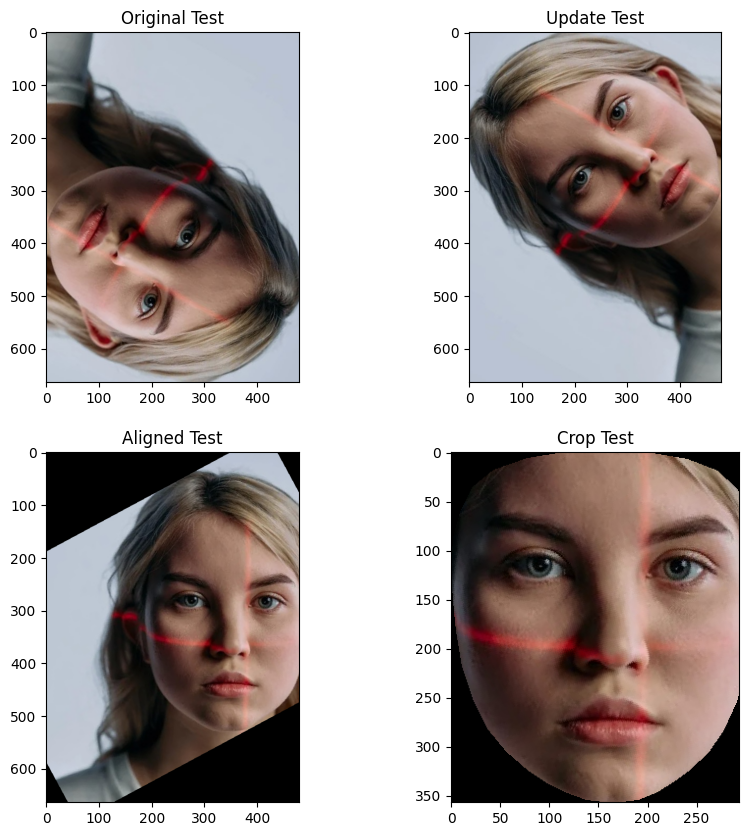

In [128]:
path = r"Img/test5.jpg"
img_obj = load_image( path )
img_obj_aug = img_obj.copy()

right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )

if right_eye_center != 0:
    img_best = align_face(img_upd, right_eye_center, left_eye_center)
    img_crop = crop_face( img_best )
else:
    print("Abort...")


fig = plt.figure(figsize = (10,10))
# plt.axis('off')
#plot 1:
plt.subplot(2, 2, 1)
plt.title("Original Test")
plt.imshow(img_obj)

#plot 2:
plt.subplot(2, 2, 2)
plt.title("Update Test")
plt.imshow(img_upd)

#plot 3:
plt.subplot(2, 2, 3)
plt.title("Aligned Test")
plt.imshow(img_best)

#plot 4:
plt.subplot(2, 2, 4)
plt.title("Crop Test")
plt.imshow(img_crop)

plt.show()

In [134]:
Image.fromarray(img_crop).save('Img/abab.jpg')

Selected Number of Faces: 1
(272, 418) (264, 271)
rotate to inverse clock direction
angle:  86.8849352400945  in degree


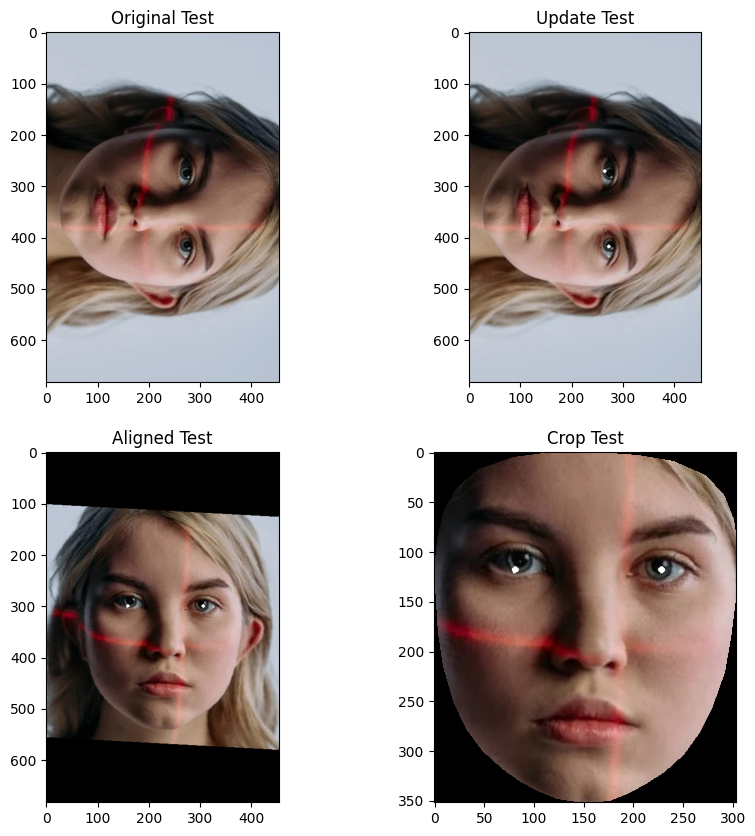

In [90]:
path = r"Img/test4.jpg"
img_obj = load_image( path )
img_obj_aug = img_obj.copy()

right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )

if right_eye_center != 0:
    img_best = align_face(img_upd, right_eye_center, left_eye_center)
    img_crop = crop_face( img_best )
else:
    print("Abort...")


fig = plt.figure(figsize = (10,10))
# plt.axis('off')
#plot 1:
plt.subplot(2, 2, 1)
plt.title("Original Test")
plt.imshow(img_obj)

#plot 2:
plt.subplot(2, 2, 2)
plt.title("Update Test")
plt.imshow(img_upd)

#plot 3:
plt.subplot(2, 2, 3)
plt.title("Aligned Test")
plt.imshow(img_best)

#plot 4:
plt.subplot(2, 2, 4)
plt.title("Crop Test")
plt.imshow(img_crop)

plt.show()

Selected Number of Faces: 1
(182, 262) (185, 405)
rotate to clock direction
angle:  88.79816693554781  in degree


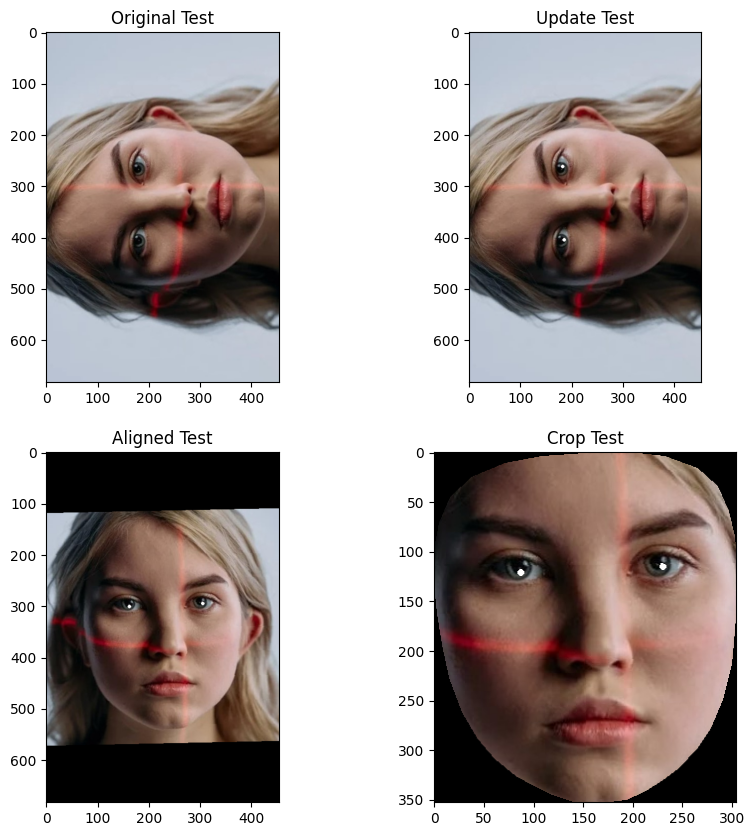

In [92]:
path = r"Img/test3.jpg"
img_obj = load_image( path )
img_obj_aug = img_obj.copy()

right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )

if right_eye_center != 0:
    img_best = align_face(img_upd, right_eye_center, left_eye_center)
    img_crop = crop_face( img_best )
else:
    print("Abort...")


fig = plt.figure(figsize = (10,10))
# plt.axis('off')
#plot 1:
plt.subplot(2, 2, 1)
plt.title("Original Test")
plt.imshow(img_obj)

#plot 2:
plt.subplot(2, 2, 2)
plt.title("Update Test")
plt.imshow(img_upd)

#plot 3:
plt.subplot(2, 2, 3)
plt.title("Aligned Test")
plt.imshow(img_best)

#plot 4:
plt.subplot(2, 2, 4)
plt.title("Crop Test")
plt.imshow(img_crop)

plt.show()

Selected Number of Faces: 1
(418, 182) (271, 185)
rotate to clock direction
angle:  1.169139327907402  in degree


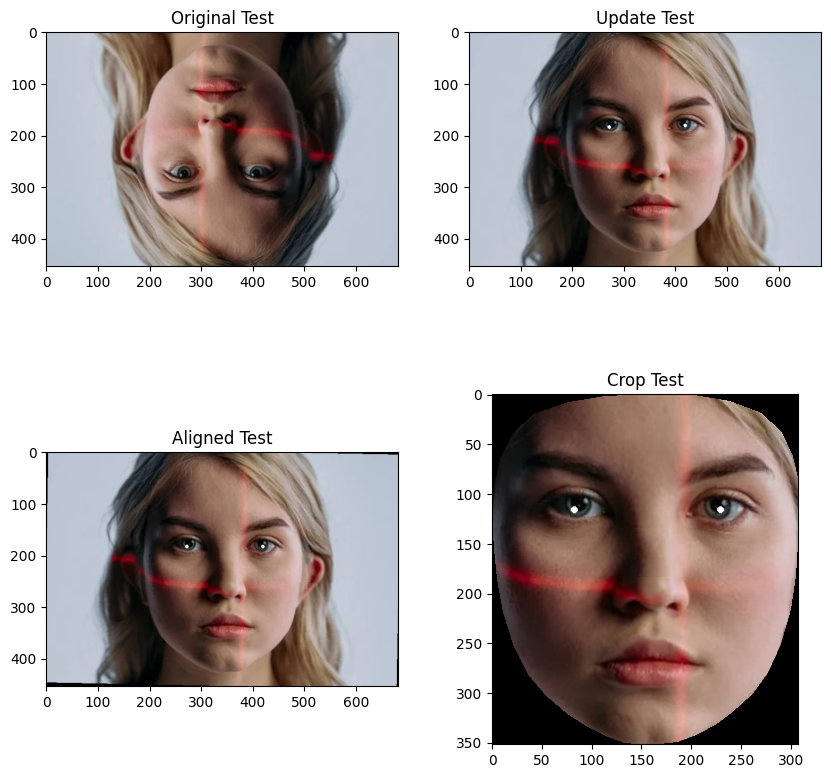

In [93]:
path = r"Img/test2.jpg"
img_obj = load_image( path )
img_obj_aug = img_obj.copy()

right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )

if right_eye_center != 0:
    img_best = align_face(img_upd, right_eye_center, left_eye_center)
    img_crop = crop_face( img_best )
else:
    print("Abort...")


fig = plt.figure(figsize = (10,10))
# plt.axis('off')
#plot 1:
plt.subplot(2, 2, 1)
plt.title("Original Test")
plt.imshow(img_obj)

#plot 2:
plt.subplot(2, 2, 2)
plt.title("Update Test")
plt.imshow(img_upd)

#plot 3:
plt.subplot(2, 2, 3)
plt.title("Aligned Test")
plt.imshow(img_best)

#plot 4:
plt.subplot(2, 2, 4)
plt.title("Crop Test")
plt.imshow(img_crop)

plt.show()

Selected Number of Faces: 1
(504, 229) (363, 261)
rotate to clock direction
angle:  12.78670144918675  in degree


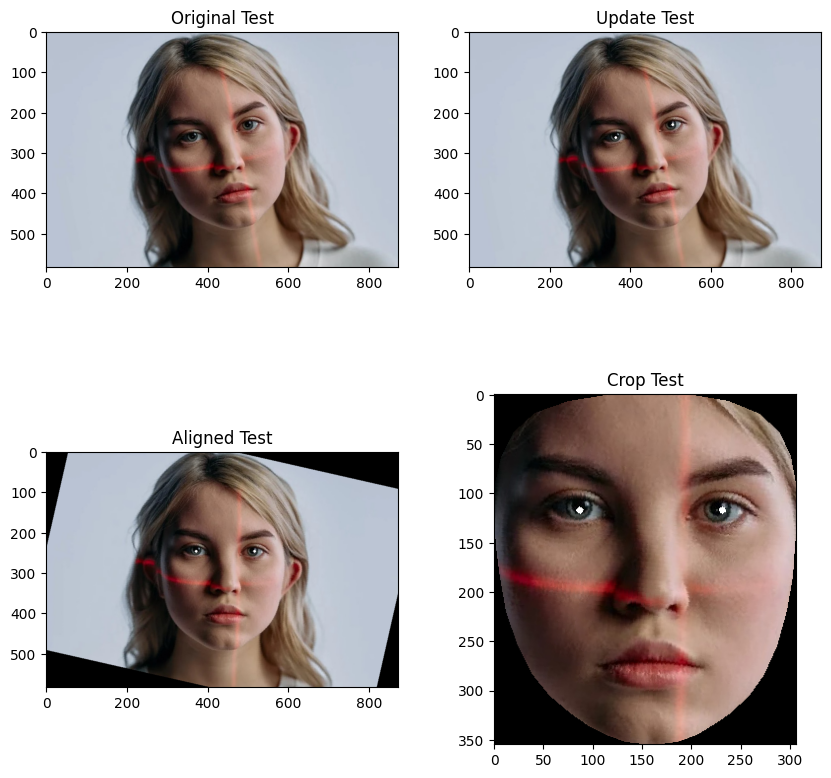

In [94]:
path = r"Img/test1.jpg"
img_obj = load_image( path )
img_obj_aug = img_obj.copy()

right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )

if right_eye_center != 0:
    img_best = align_face(img_upd, right_eye_center, left_eye_center)
    img_crop = crop_face( img_best )
else:
    print("Abort...")


fig = plt.figure(figsize = (10,10))
# plt.axis('off')
#plot 1:
plt.subplot(2, 2, 1)
plt.title("Original Test")
plt.imshow(img_obj)

#plot 2:
plt.subplot(2, 2, 2)
plt.title("Update Test")
plt.imshow(img_upd)

#plot 3:
plt.subplot(2, 2, 3)
plt.title("Aligned Test")
plt.imshow(img_best)

#plot 4:
plt.subplot(2, 2, 4)
plt.title("Crop Test")
plt.imshow(img_crop)

plt.show()

In [ ]:
path = r"Img/r11.jpg"
img_obj = load_image( path )
img_obj_aug = img_obj.copy()

right_eye_center, left_eye_center, img_upd = find_imp_cord(img_obj_aug )

if right_eye_center != 0:
    img_best = align_face(img_upd, right_eye_center, left_eye_center)
    img_crop = crop_face( img_best )
else:
    print("Abort...")


fig = plt.figure(figsize = (10,10))
# plt.axis('off')
#plot 1:
plt.subplot(2, 2, 1)
plt.title("Original Test")
plt.imshow(img_obj)

#plot 2:
plt.subplot(2, 2, 2)
plt.title("Update Test")
plt.imshow(img_upd)

#plot 3:
plt.subplot(2, 2, 3)
plt.title("Aligned Test")
plt.imshow(img_best)

#plot 4:
plt.subplot(2, 2, 4)
plt.title("Crop Test")
plt.imshow(img_crop)

plt.show()

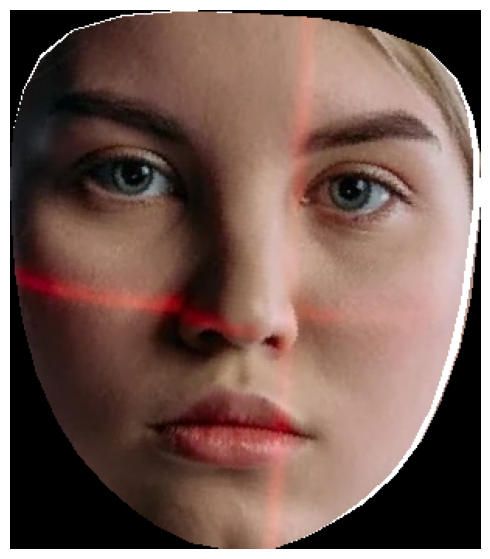

In [16]:
def crop_face( img ):
    mp_face_mesh = mediapipe.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
    results = face_mesh.process( img )
    
    landmarks = results.multi_face_landmarks[0]
    abc = mp_face_mesh.FACEMESH_FACE_OVAL
    df = pd.DataFrame(list( abc ), columns = ["p1", "p2"])
    
    routes_idx = []
    p1 = df.iloc[0]["p1"]
    p2 = df.iloc[0]["p2"]
    
    for i in range(0, df.shape[0]):
        obj = df[df["p1"] == p2]
        p1 = obj["p1"].values[0]
        p2 = obj["p2"].values[0]
        route_idx = []
        route_idx.append(p1)
        route_idx.append(p2)
        routes_idx.append(route_idx)
    
    routes = []
    for source_idx, target_idx in routes_idx:
        source = landmarks.landmark[source_idx]
        target = landmarks.landmark[target_idx]
            
        relative_source = (int(img.shape[1] * source.x), int(img.shape[0] * source.y))
        relative_target = (int(img.shape[1] * target.x), int(img.shape[0] * target.y))
    
        # cv2.line(img, relative_source, relative_target, (255, 255, 255), thickness = 2)
        # print(relative_source, relative_target)
        routes.append(relative_source)
        routes.append(relative_target)
    
    mask = np.zeros((img.shape[0], img.shape[1]))
    mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
    mask = mask.astype(bool)
     
    out = np.zeros_like(img)
    out[mask] = img[mask]
    
    df1 = pd.DataFrame(routes, columns = ["p1", "p2"])
    x1,y1,x2,y2 = min(df1['p1']), min(df1['p2']), max(df1['p1']), max(df1['p2']) 
    # img1 = img[y1:y2, x1:x2]
    img1 = out[y1:y2, x1:x2]
    return img1


img1 = crop_face( img )
fig = plt.figure(figsize = (7,7))
plt.axis('off')
plt.imshow(img1)

In [ ]:

def get_imp_cord(img ):
    results = face_detector.process(img)
    imp_cord = {}
    if results.detections:
        if len(results.detections)==1:
            print("Selected Number of Faces:", len(results.detections))
            for face in results.detections:
                confidence = face.score[0]
                print("Face confidence:", confidence)
                bounding_box = face.location_data.relative_bounding_box
    
                x = int(bounding_box.xmin * img.shape[1])
                w = int(bounding_box.width * img.shape[1])
                y = int(bounding_box.ymin * img.shape[0])
                h = int(bounding_box.height * img.shape[0])
                
            # cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), thickness = 2)
    
            landmarks = face.location_data.relative_keypoints
         
            right_eye = (int(landmarks[0].x * img.shape[1]), int(landmarks[0].y * img.shape[0]))
            left_eye = (int(landmarks[1].x * img.shape[1]), int(landmarks[1].y * img.shape[0]))
            nose = (int(landmarks[2].x * img.shape[1]), int(landmarks[2].y * img.shape[0]))
            mouth = (int(landmarks[3].x * img.shape[1]), int(landmarks[3].y * img.shape[0]))
            # right_ear = (int(landmarks[4].x * img.shape[1]), int(landmarks[4].y * img.shape[0]))
            # left_ear = (int(landmarks[5].x * img.shape[1]), int(landmarks[5].y * img.shape[0]))
            imp_cord['R-EYE'] = right_eye
            imp_cord['L-EYE'] = left_eye
            # imp_cord['NOSE'] = nose
            # imp_cord['mouth'] = mouth
            # cv2.circle(img, right_eye, 1, (255, 0, 0), -1)
            # cv2.circle(img, left_eye, 1, (255, 0, 0), -1)
            # cv2.circle(img, nose, 7, (255, 0, 0), -1)
            # cv2.circle(img, mouth, 7, (255, 0, 0), -1)
        else:
            print("more than one face")
    else:
        print("No Detection")
    return imp_cord, img

In [4]:
def align_face(imp_cord, img_obj):
    eye_1 = imp_cord['L-EYE']
    eye_2 = imp_cord['R-EYE']
    #--------------------
    #decide left and right eye
    if eye_1[0] < eye_2[0]:
        left_eye = eye_1
        right_eye = eye_2
    else:
        left_eye = eye_2
        right_eye = eye_1
    
    left_eye_x = left_eye[0]
    left_eye_y = left_eye[1]
    right_eye_x = right_eye[0]
    right_eye_y =right_eye[1]
    #----------------------
    #find rotation direction
    if left_eye_y > right_eye_y:
        point_3rd = (right_eye_x, left_eye_y)
        direction = -1 #rotate same direction to clock
        print("rotate to clock direction")
    else:
        point_3rd = (left_eye_x, right_eye_y)
        direction = 1 #rotate inverse direction of clock
        print("rotate to inverse clock direction")
    
    def euclidean_distance(a, b):
    	x1 = a[0]; y1 = a[1]
    	x2 = b[0]; y2 = b[1]
    
    	return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))
        
    #----------------------
    #find angle
    a = euclidean_distance(left_eye, point_3rd) # math.dist(left_eye, point_3rd)
    b = euclidean_distance(right_eye, point_3rd)
    c = euclidean_distance(right_eye, left_eye)
    
    cos_a = (b*b + c*c - a*a)/(2*b*c)
    #print("cos(a) = ", cos_a)
    angle = np.arccos(cos_a)
    #print("angle: ", angle," in radian")
    
    angle = (angle * 180) / math.pi
    # print("angle: ", angle," in degree")
    
    if direction == -1:
        angle = 90 - angle
    
    print("angle: ", angle," in degree")
    #--------------------
    #rotate image
    
    new_img = Image.fromarray(img_obj)
    new_img = np.array(new_img.rotate(direction * angle))
    return new_img

rotate to clock direction
angle:  15.89283098033738  in degree


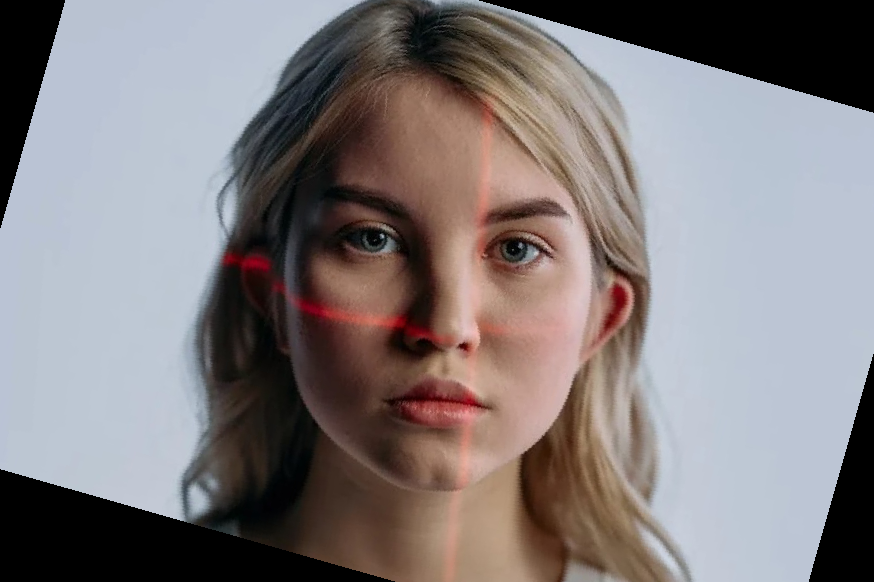

In [5]:
Image.fromarray(new_img)

In [132]:
cv2.waitKey()
#press any key to close the windows
cv2.destroyAllWindows()